In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import cv2 
from PIL import Image
import matplotlib.pyplot as plt

In [1]:
!pip install matplotlib

In [188]:
!pip install scikit-learn

In [3]:
dataset_path = 'dataset/faces'

In [1]:
!pip install keras
!pip install tensorflow

  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached h5py-3.11.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached optree-0.12.1-cp312-cp312-win_amd64.whl.metadata (48 kB)
  Using cached ml_dtypes-0.4.0-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached h5py-3.11.0-cp312-cp312-win_amd64.whl (3.0 MB)
Using cached ml_dtypes-0.4.0-cp312-cp312-win_amd64.whl (127 kB)
Using cached namex-0.0.8-py3-none-any.whl (5.8 kB)
Using cached optree-0.12.1-cp312-cp312-win_a

In [4]:
#TAKING A RANDOM IMAGE TO DEFINE IMAGE SIZE
filepath = "dataset/faces/Ajay/face_100.jpg"
img = Image.open(filepath)
width = img.width 
height = img.height 
print("The height of the image is: ", height) 
print("The width of the image is: ", width) 

The height of the image is:  256
The width of the image is:  256


In [5]:
#TO RESIZE THE IMAGES
image_size = (256, 256)
#TO STORE FACE DB
face_db = []

In [6]:
#TO ACCESS ALL IMAGES IMAGES IN THE GIVEN DATASET AND PREPROCESS THEM
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)#READ IMG
        img_resized = cv2.resize(img, image_size)#RESIZE IN SPECIFIED SIZE
        img_vector = img_resized.flatten()
        face_db.append(img_vector)                

In [7]:
face_db_matrix = np.array(face_db).T  # Transpose to get the shape


In [8]:
print("Face database shape:", face_db_matrix.shape)


Face database shape: (65536, 450)


In [9]:
# Calculate the mean image
mean_image = np.mean(face_db_matrix, axis=1)
print("Mean image shape:", mean_image.shape)

Mean image shape: (65536,)


In [10]:
#MEAN ZERO CALCULATION
mean_zeroed_db = face_db_matrix - mean_image[:, np.newaxis]
print("Mean-zeroed face database shape:", mean_zeroed_db.shape)

Mean-zeroed face database shape: (65536, 450)


In [11]:
# Number of images
p = face_db_matrix.shape[1]

In [12]:
# Calculate the covariance matrix 
cov_matrix = np.dot(mean_zeroed_db.T, mean_zeroed_db) / p
print("Covariance matrix shape:", cov_matrix.shape)

Covariance matrix shape: (450, 450)


In [13]:
#Calculate the eigenvalues and eigen vectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [14]:
# Sort the eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


In [15]:
#selecting top k eigenvectors
k = 200 
#tried with various k values.
selected_eigenvectors = sorted_eigenvectors[:, :k]
print("Selected eigenvectors shape:", selected_eigenvectors.shape)

Selected eigenvectors shape: (450, 200)


In [16]:
#eigen face generation
eigenfaces = np.dot(selected_eigenvectors.T, mean_zeroed_db.T)
print("Eigenfaces shape:", eigenfaces.shape)

Eigenfaces shape: (200, 65536)


In [17]:
#creating unique face signature for each face in db
face_signatures = np.dot(eigenfaces, mean_zeroed_db)
print("Face signatures shape:", face_signatures.shape)

Face signatures shape: (200, 450)


In [18]:
#Generating labels
labels = []

for label, folder_name in enumerate(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder_name)
    for file_name in os.listdir(folder_path):
        labels.append(label)
labels = np.array(labels)

In [19]:
X = face_signatures.T
y = to_categorical(labels)

In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    tf.keras.layers.Dense(32, activation='relu'),  # Second hidden layer
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Check the data type of X_train and y_train
print(X_train.dtype, y_train.dtype)

# If they are complex, convert them to real values (e.g., float32)
if np.iscomplexobj(X_train):
    X_train = X_train.real.astype('float32')

if np.iscomplexobj(X_test):
    X_test = X_test.real.astype('float32')

if np.iscomplexobj(y_train):
    y_train = y_train.real.astype('float32')

if np.iscomplexobj(y_test):
    y_test = y_test.real.astype('float32')

# Now try training the model again
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))


complex128 float64
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1425 - loss: 86433032.0000 - val_accuracy: 0.1778 - val_loss: 32246170.0000
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3505 - loss: 21161262.0000 - val_accuracy: 0.3556 - val_loss: 21655012.0000
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4134 - loss: 12532569.0000 - val_accuracy: 0.3222 - val_loss: 17191234.0000
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4866 - loss: 7761730.5000 - val_accuracy: 0.4222 - val_loss: 15758916.0000
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 4256470.5000 - val_accuracy: 0.3889 - val_loss: 13507925.0000
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7078 - loss: 2404942.0000 - val_accuracy: 0.4000 - val_loss: 12966757.0000
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7261 - loss: 2172245.5000 - val_accuracy: 0.4111 - val_loss: 12505562.0000
Epoc

In [47]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
accuracy_percentage = accuracy * 100

# Print the accuracy
print(f"Test Accuracy: {accuracy_percentage:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5490 - loss: 10392453.0000 
Test Accuracy: 56.67%


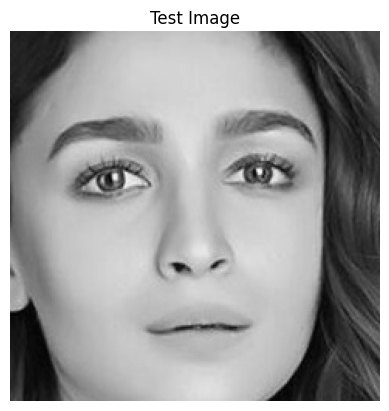

In [51]:
test_image_path = 'Alia.jpg'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Display the image using matplotlib
plt.imshow(test_image, cmap='gray')
plt.title('Test Image')
plt.axis('off')
plt.show()


In [52]:
test_image = cv2.resize(test_image, (256,256))


In [53]:
#Flatten the Image into a Column Vector
mn = test_image.shape[0] * test_image.shape[1]
test_image_vector = test_image.flatten().reshape(mn, 1)

In [54]:
# Verify the shape
print("Test Image as Column Vector Shape:", test_image_vector.shape)

Test Image as Column Vector Shape: (65536, 1)


In [55]:
mean_image = mean_image.reshape(-1, 1)
test_image_vector = test_image_vector.reshape(-1, 1) 

In [56]:
#Mean Zero for test img
mean_zero_test_image = test_image_vector - mean_image
print("Mean Zero Test Image Shape:", mean_zero_test_image.shape)

Mean Zero Test Image Shape: (65536, 1)


In [57]:
projected_test_face = np.dot(eigenfaces, mean_zero_test_image)
print("Projected Test Face Shape:", projected_test_face.shape)

Projected Test Face Shape: (200, 1)


In [58]:
# Ensure the projected test face is real by taking the real part
projected_test_face_real = np.real(projected_test_face)

# Reshape the projected test face to match the input shape expected by the ANN
projected_test_face_reshaped = projected_test_face_real.T

# Predict the class (face identity) using the trained ANN
predicted_class = model.predict(projected_test_face_reshaped)

# Print the predicted class
print("Predicted class for the test face:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted class for the test face: [[0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [59]:
# Assuming you have a list of class names, where the order corresponds to the encoding
class_names = ["Aamir", "Ajay", "Akshay", "Alia", "Amitabh", "Deepika", "Disha", "Farhan", "Ileana"]

# Get the index of the maximum value in the predicted vector
predicted_index = np.argmax(predicted_class)

# Map this index to the class name
predicted_class_name = class_names[predicted_index]

# Print the predicted class name
print("Predicted class for the test face:", predicted_class_name)


Predicted class for the test face: Alia


In [60]:
from sklearn.metrics import accuracy_score, classification_report

# Predict classes for the entire test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions back to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [61]:
# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.5666666666666667


In [62]:
# Classification report
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

       Aamir       0.57      0.33      0.42        12
        Ajay       0.61      0.79      0.69        14
      Akshay       0.67      0.44      0.53         9
        Alia       0.25      0.43      0.32         7
     Amitabh       0.57      1.00      0.73         8
     Deepika       0.38      0.38      0.38         8
       Disha       0.57      0.67      0.62         6
      Farhan       0.89      0.57      0.70        14
      Ileana       0.67      0.50      0.57        12

    accuracy                           0.57        90
   macro avg       0.57      0.57      0.55        90
weighted avg       0.61      0.57      0.56        90

